In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-21-2020.csv')

In [3]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,784,840,906,933,996,1026,1092,1176,1279,1351
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,494,518,539,548,562,584,609,634,663,678
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,673,673,696,704,713,717,717,723,723,731
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,24,24,24,24,25,25,25


In [4]:
cols = confirmed_df.keys()

In [5]:
#getting all the dates
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [6]:
dates = confirmed.keys()

world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
us_cases = []
us_recovery_rate = []
us_mortality_rate = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)
    
    confirmed_sum_us = confirmed_df[confirmed_df['Country/Region']=='US'][i].sum()
    death_sum_us = deaths_df[deaths_df['Country/Region']=='US'][i].sum()
    recovery_sum_us = recoveries_df[recoveries_df['Country/Region']=='US'][i].sum()

    us_cases.append(confirmed_sum_us)
    us_recovery_rate.append(recovery_sum_us/confirmed_sum_us)
    us_mortality_rate.append(death_sum_us/confirmed_sum_us)


In [7]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

world_daily_increase = daily_increase(world_cases)
us_daily_increase = daily_increase(us_cases)

In [8]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)
us_cases = np.array(us_cases).reshape(-1,1)
us_recovery_rate = np.array(us_recovery_rate).reshape(-1,1)
us_mortality_rate = np.array(us_mortality_rate).reshape(-1,1)


In [9]:
# Setting the Number of Days in future for predicition...Number of days can be altered here
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [10]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [11]:
# Splitting training and testing data

X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, us_cases, test_size=0.05, shuffle=False)
X_train_rr, X_test_rr, y_train_rr, y_test_rr = train_test_split(days_since_1_22, us_recovery_rate, test_size=0.05, shuffle=False)
X_train_mr, X_test_mr, y_train_mr, y_test_mr = train_test_split(days_since_1_22, us_mortality_rate, test_size=0.05, shuffle=False)

In [12]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=6, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
#predicting next ten days 
svm_pred = svm_confirmed.predict(future_forcast)

svm_rr = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=6, C=0.1)
svm_rr.fit(X_train_rr, y_train_rr)
#predicting next ten days 
svm_pred_rr = svm_rr.predict(future_forcast)

svm_mr = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=6, C=0.1)
svm_mr.fit(X_train_mr, y_train_mr)
#predicting next ten days 
svm_pred_mr = svm_mr.predict(future_forcast)

MAE: 189670.1883468712
MSE: 38869650921.93425


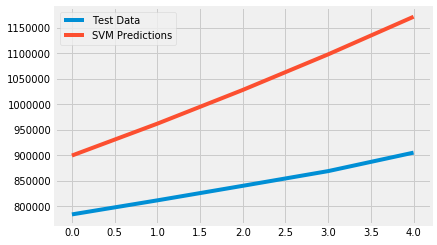

In [13]:
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:', mean_squared_error(svm_test_pred, y_test_confirmed))

In [14]:
#confirmed cases
poly = PolynomialFeatures(degree=3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

bayesian_poly = PolynomialFeatures(degree=4)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

#recovery rate
poly_rr = PolynomialFeatures(degree=3)
poly_X_train_rr = poly_rr.fit_transform(X_train_rr)
poly_X_test_rr = poly_rr.fit_transform(X_test_rr)
poly_future_forcast_rr = poly_rr.fit_transform(future_forcast)

bayesian_poly_rr = PolynomialFeatures(degree=4)
bayesian_poly_X_train_rr = bayesian_poly_rr.fit_transform(X_train_rr)
bayesian_poly_X_test_rr = bayesian_poly_rr.fit_transform(X_test_rr)
bayesian_poly_future_forcast_rr = bayesian_poly_rr.fit_transform(future_forcast)

#mortality rate
poly_mr = PolynomialFeatures(degree=3)
poly_X_train_mr = poly_mr.fit_transform(X_train_mr)
poly_X_test_mr = poly_mr.fit_transform(X_test_mr)
poly_future_forcast_mr = poly_mr.fit_transform(future_forcast)

bayesian_poly_mr = PolynomialFeatures(degree=4)
bayesian_poly_X_train_mr = bayesian_poly_mr.fit_transform(X_train_mr)
bayesian_poly_X_test_mr = bayesian_poly_mr.fit_transform(X_test_mr)
bayesian_poly_future_forcast_mr = bayesian_poly_mr.fit_transform(future_forcast)

In [15]:
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

#for recovery rate
linear_model_rr = LinearRegression(normalize=True, fit_intercept=False)
linear_model_rr.fit(poly_X_train_rr, y_train_rr)
test_linear_pred_rr = linear_model_rr.predict(poly_X_test_rr)
linear_pred_rr = linear_model_rr.predict(poly_future_forcast_rr)

#for mortality rate
linear_model_mr = LinearRegression(normalize=True, fit_intercept=False)
linear_model_mr.fit(poly_X_train_mr, y_train_mr)
test_linear_pred_mr = linear_model_mr.predict(poly_X_test_mr)
linear_pred_mr = linear_model_mr.predict(poly_future_forcast_mr)

MAE: 104390.43296072516
MSE: 11689208391.950111


In [16]:
print(linear_model.coef_)

[[-3.28855621e+04  7.93965787e+03 -3.67516088e+02  4.37745985e+00]]


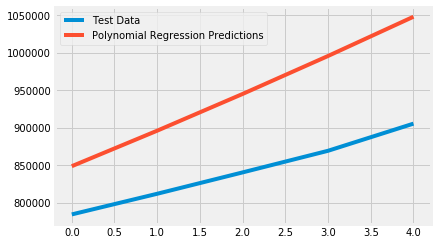

In [17]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [18]:
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

bayesian_search_rr = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search_rr.fit(bayesian_poly_X_train_rr, y_train_rr)

bayesian_search_mr = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search_mr.fit(bayesian_poly_X_train_mr, y_train_mr)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.1s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           compute_score=False, copy_X=True,
                                           fit_intercept=False, lambda_1=1e-06,
                                           lambda_2=1e-06, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                 

In [19]:
bayesian_search.best_params_
bayesian_search_rr.best_params_
bayesian_search_mr.best_params_

{'tol': 1e-05,
 'normalize': True,
 'lambda_2': 1e-07,
 'lambda_1': 0.001,
 'alpha_2': 0.001,
 'alpha_1': 1e-06}

In [20]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

#for rr
bayesian_rr = bayesian_search_rr.best_estimator_
test_bayesian_pred_rr = bayesian_rr.predict(bayesian_poly_X_test_rr)
bayesian_pred_rr = bayesian_rr.predict(bayesian_poly_future_forcast_rr)

#for mr
bayesian_mr = bayesian_search_mr.best_estimator_
test_bayesian_pred_mr = bayesian_mr.predict(bayesian_poly_X_test_mr)
bayesian_pred_mr = bayesian_mr.predict(bayesian_poly_future_forcast_mr)

MAE: 136160.25409448566
MSE: 19889744113.38679


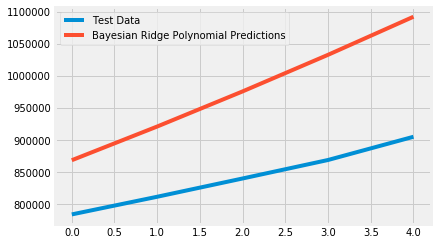

In [21]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

In [22]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('# of Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
    print(pred[-1])

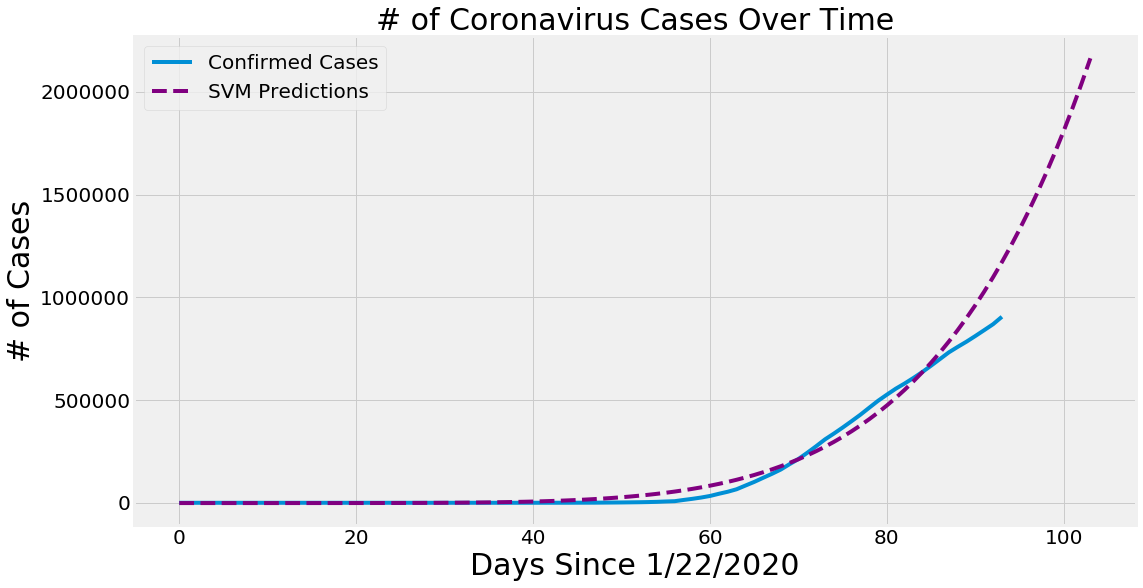

2163326.110993966


In [23]:
plot_predictions(adjusted_dates, us_cases, svm_pred, 'SVM Predictions', 'purple')

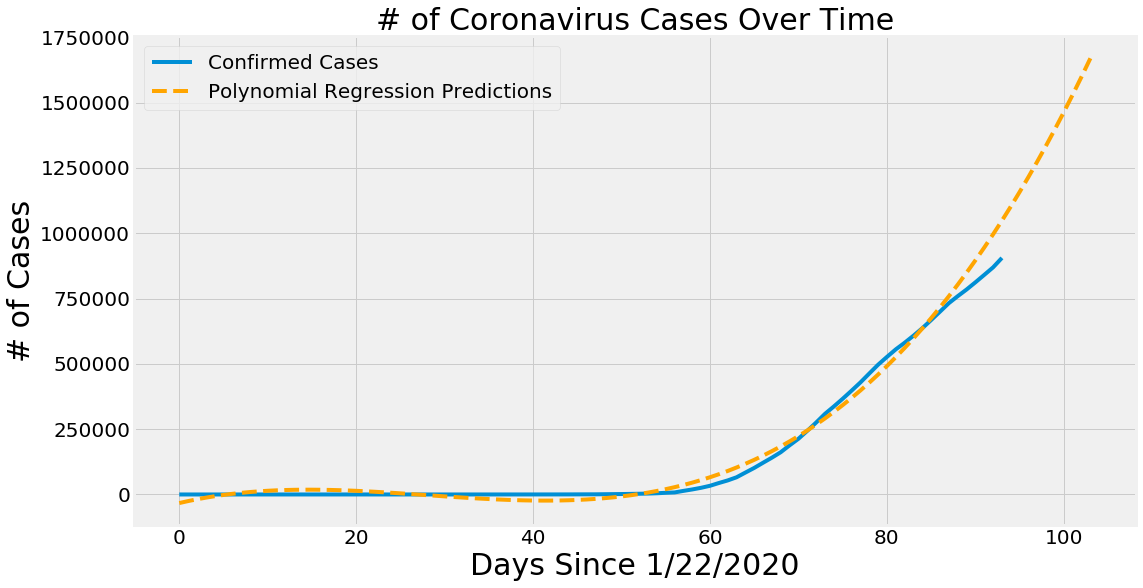

[1669289.58505219]


In [24]:
plot_predictions(adjusted_dates, us_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

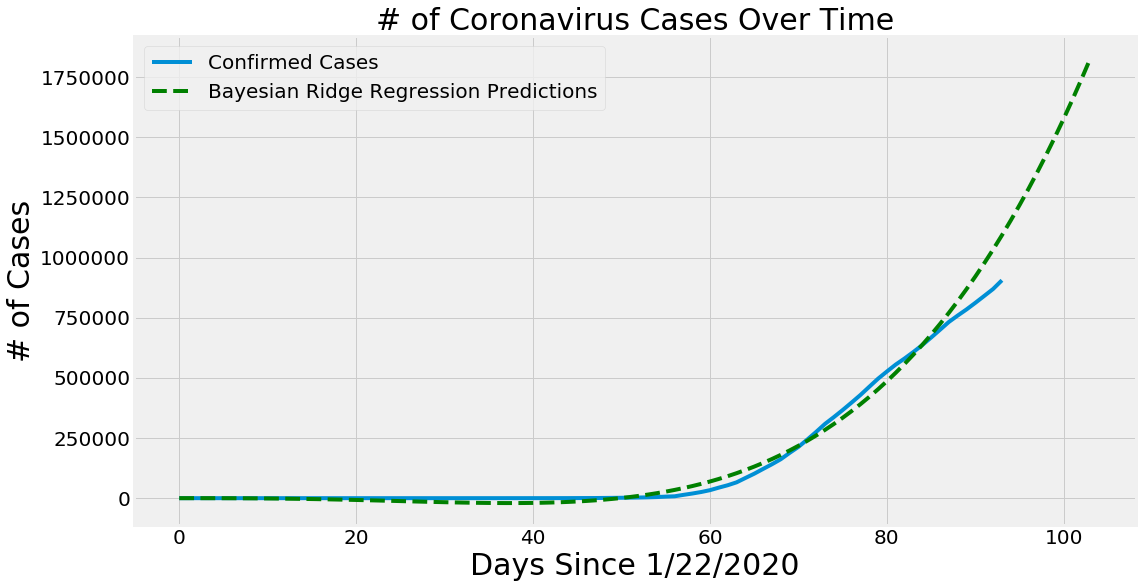

1827776.7259276304


In [25]:
plot_predictions(adjusted_dates, us_cases, bayesian_pred, 'Bayesian Ridge Regression Predictions', 'green')

In [26]:
def plot_predictions_rr(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Recovery rate over time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('Recovery Rate', size=30)
    plt.legend(['Recovery Rate', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
    print(pred[-1])

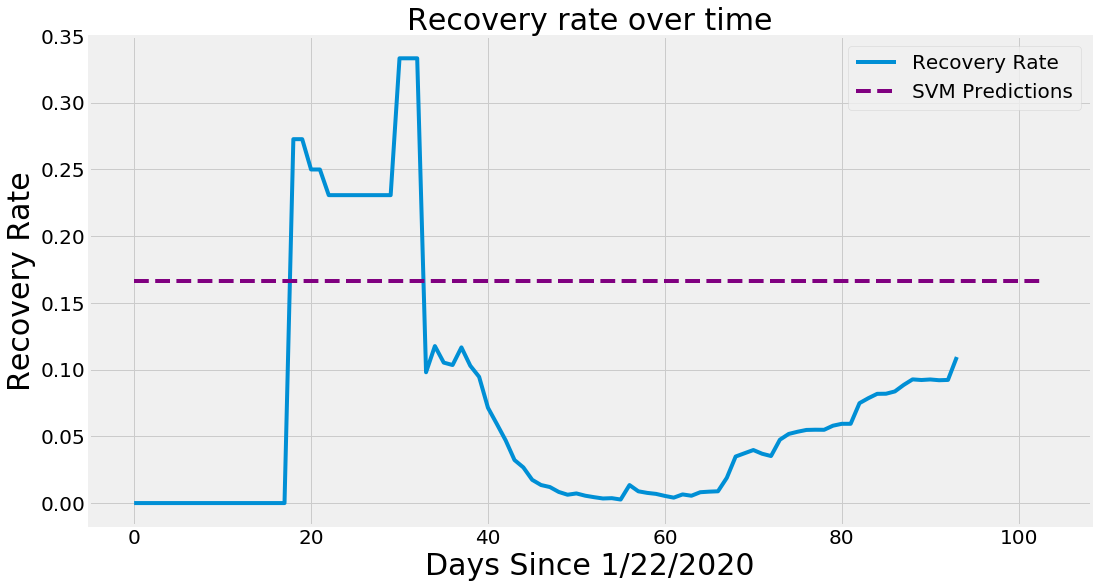

0.16666666666666663


In [27]:
plot_predictions_rr(adjusted_dates,us_recovery_rate, svm_pred_rr, 'SVM Predictions', 'purple')

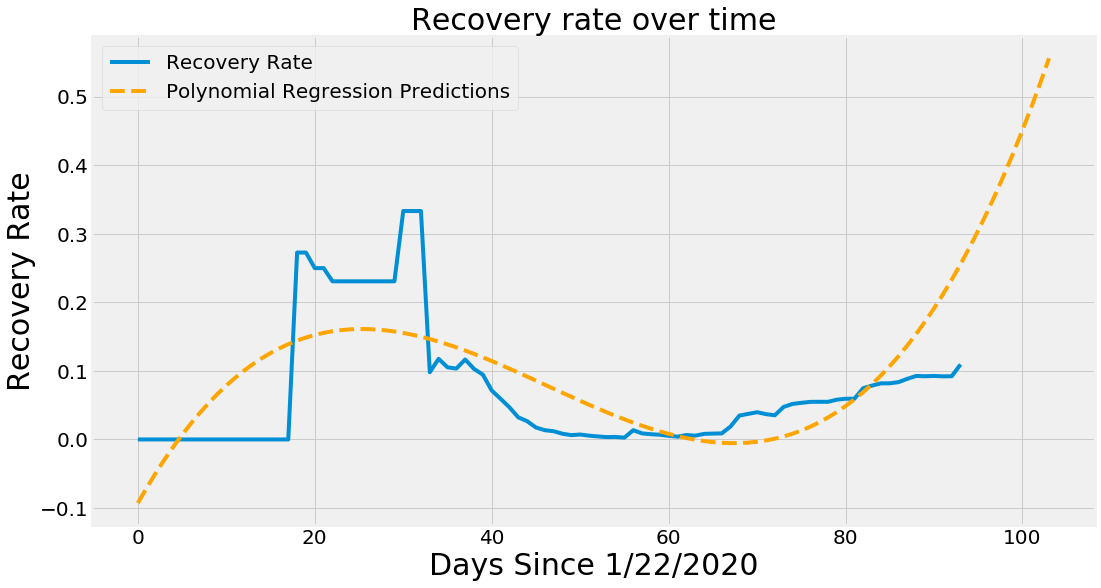

[0.5562246]


In [28]:
plot_predictions_rr(adjusted_dates,us_recovery_rate,linear_pred_rr , 'Polynomial Regression Predictions', 'orange')

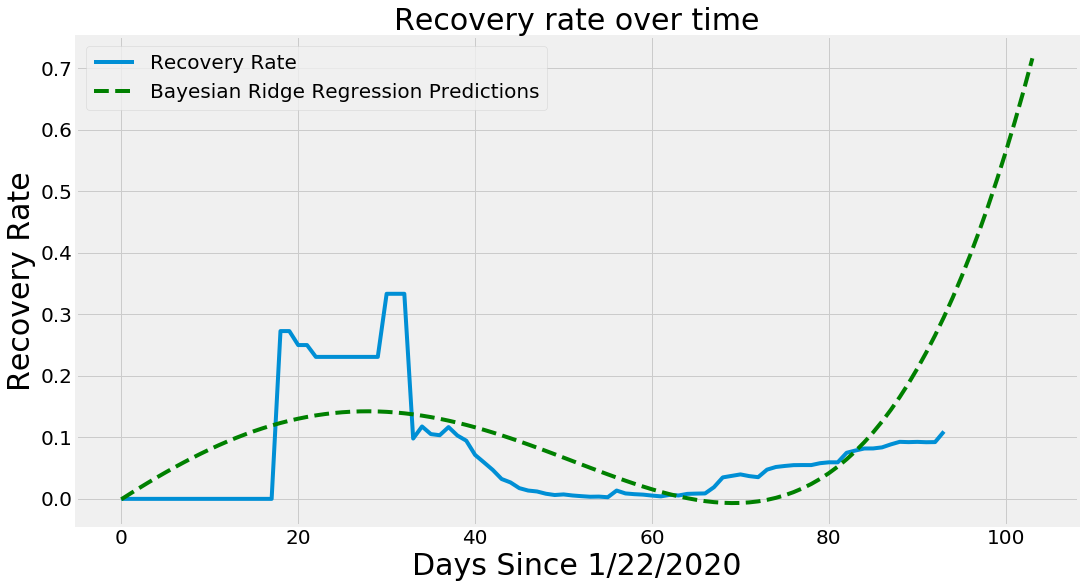

0.7161317921380208


In [29]:
plot_predictions_rr(adjusted_dates,us_recovery_rate, bayesian_pred_rr, 'Bayesian Ridge Regression Predictions', 'green')

In [30]:
def plot_predictions_mr(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('Mortality rate over time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('Mortality Rate', size=30)
    plt.legend(['Mortality Rate', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()
    print(pred[-1])

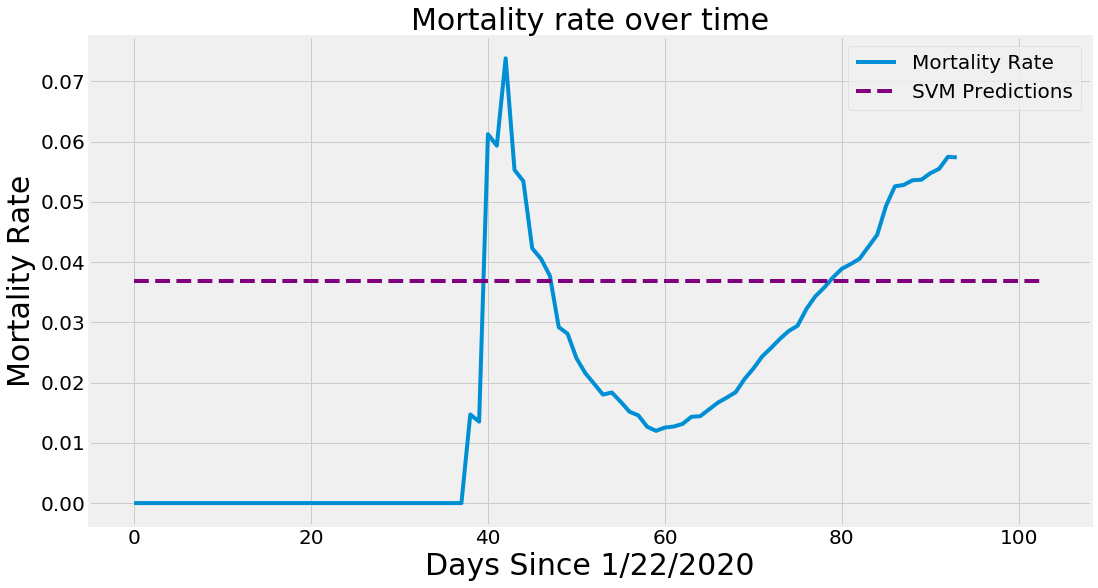

0.03691275167785235


In [31]:
plot_predictions_mr(adjusted_dates,us_mortality_rate, svm_pred_mr, 'SVM Predictions', 'purple')

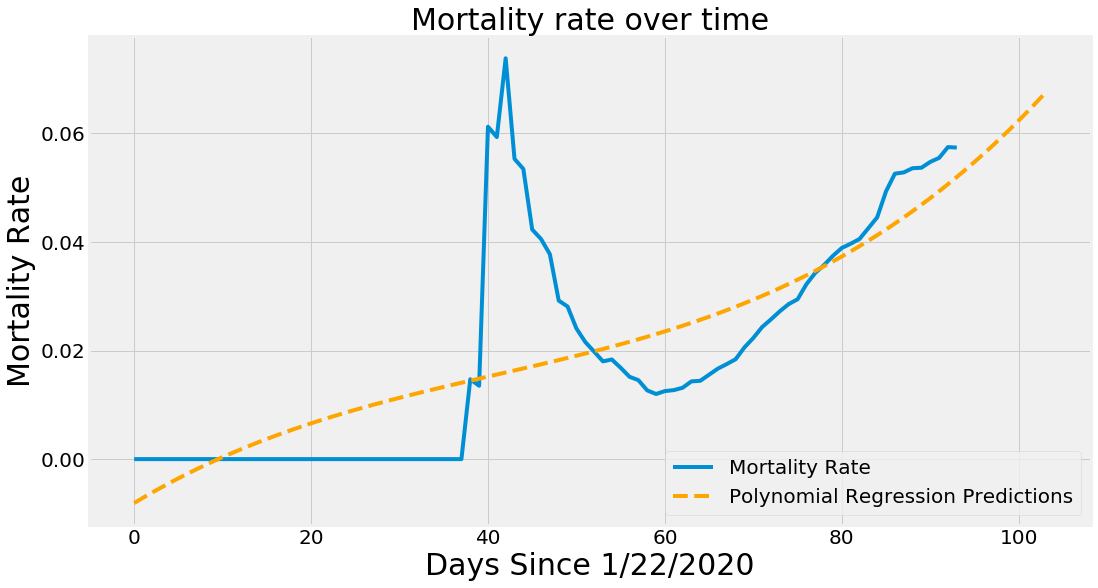

[0.06744703]


In [32]:
plot_predictions_mr(adjusted_dates,us_mortality_rate,linear_pred_mr , 'Polynomial Regression Predictions', 'orange')

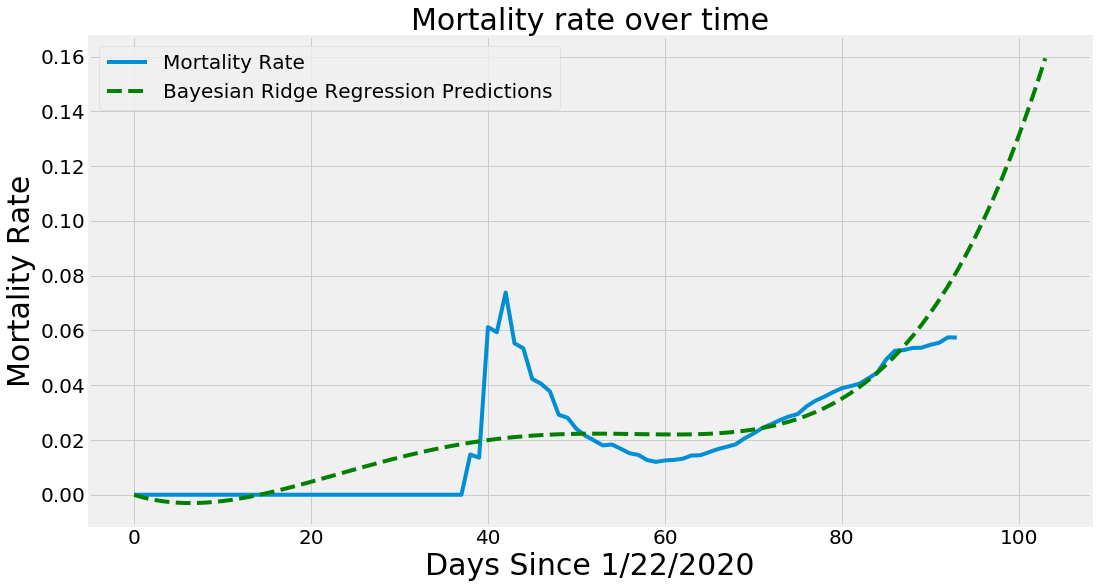

0.15934912842955962


In [33]:
plot_predictions_mr(adjusted_dates,us_mortality_rate, bayesian_pred_mr, 'Bayesian Ridge Regression Predictions', 'green')